<a href="https://colab.research.google.com/github/nuwanc/ml/blob/main/bakery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Setting the date range for two months
date_range = pd.date_range(start="2024-07-01", end="2024-08-31", freq='D')

# Bakery items
bakery_items = ["Bread", "Fish Bun", "Hotdog Bun", "Tea Bun"]

# Initialize empty list to store data
data = []

# Generate data for each day
for date in date_range:
    weekday = date.weekday()  # Monday is 0, Sunday is 6
    is_weekend = weekday >= 5  # Saturday and Sunday
    is_holiday = np.random.choice([False, True], p=[0.9, 0.1])  # 10% chance of holiday
    is_promotion = np.random.choice([False, True], p=[0.85, 0.15])  # 15% chance of promotion

    for item in bakery_items:
        # Determine base production based on day type
        if is_weekend:
            base_production = np.random.randint(120, 160)
        elif weekday == 4:  # Friday
            base_production = np.random.randint(100, 120)
        else:  # Monday to Thursday
            base_production = np.random.randint(80, 100)

        if is_holiday or is_promotion:
            base_production = int(base_production * 1.3)  # Increase production on holidays or promotions

        # Sales are generally slightly less than production
        sales = np.random.randint(int(base_production * 0.8), base_production + 1)

        # Leftover is the difference between production and sales
        leftover = base_production - sales

        data.append([date, item, base_production, sales, leftover, is_holiday, is_promotion])

# Create DataFrame
columns = ["Date", "Item", "Produced", "Sold", "Leftover", "Holiday", "Promotion"]
bakery_sales_df = pd.DataFrame(data, columns=columns)

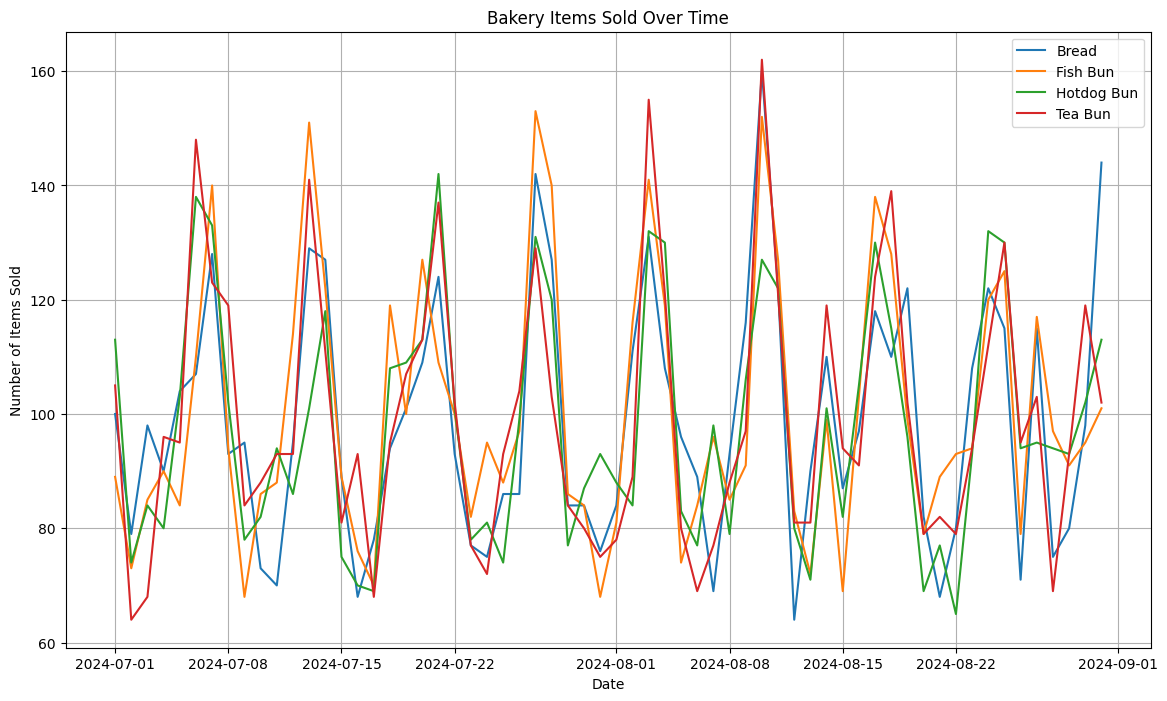

In [4]:
import matplotlib.pyplot as plt

# Aggregate the data by date for each item
aggregated_data = bakery_sales_df.groupby(['Date', 'Item']).sum().reset_index()

# Plotting the time series for each item
plt.figure(figsize=(14, 8))
for item in bakery_items:
    item_data = aggregated_data[aggregated_data['Item'] == item]
    plt.plot(item_data['Date'], item_data['Sold'], label=item)

plt.title('Bakery Items Sold Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Items Sold')
plt.legend()
plt.grid(True)
plt.show()


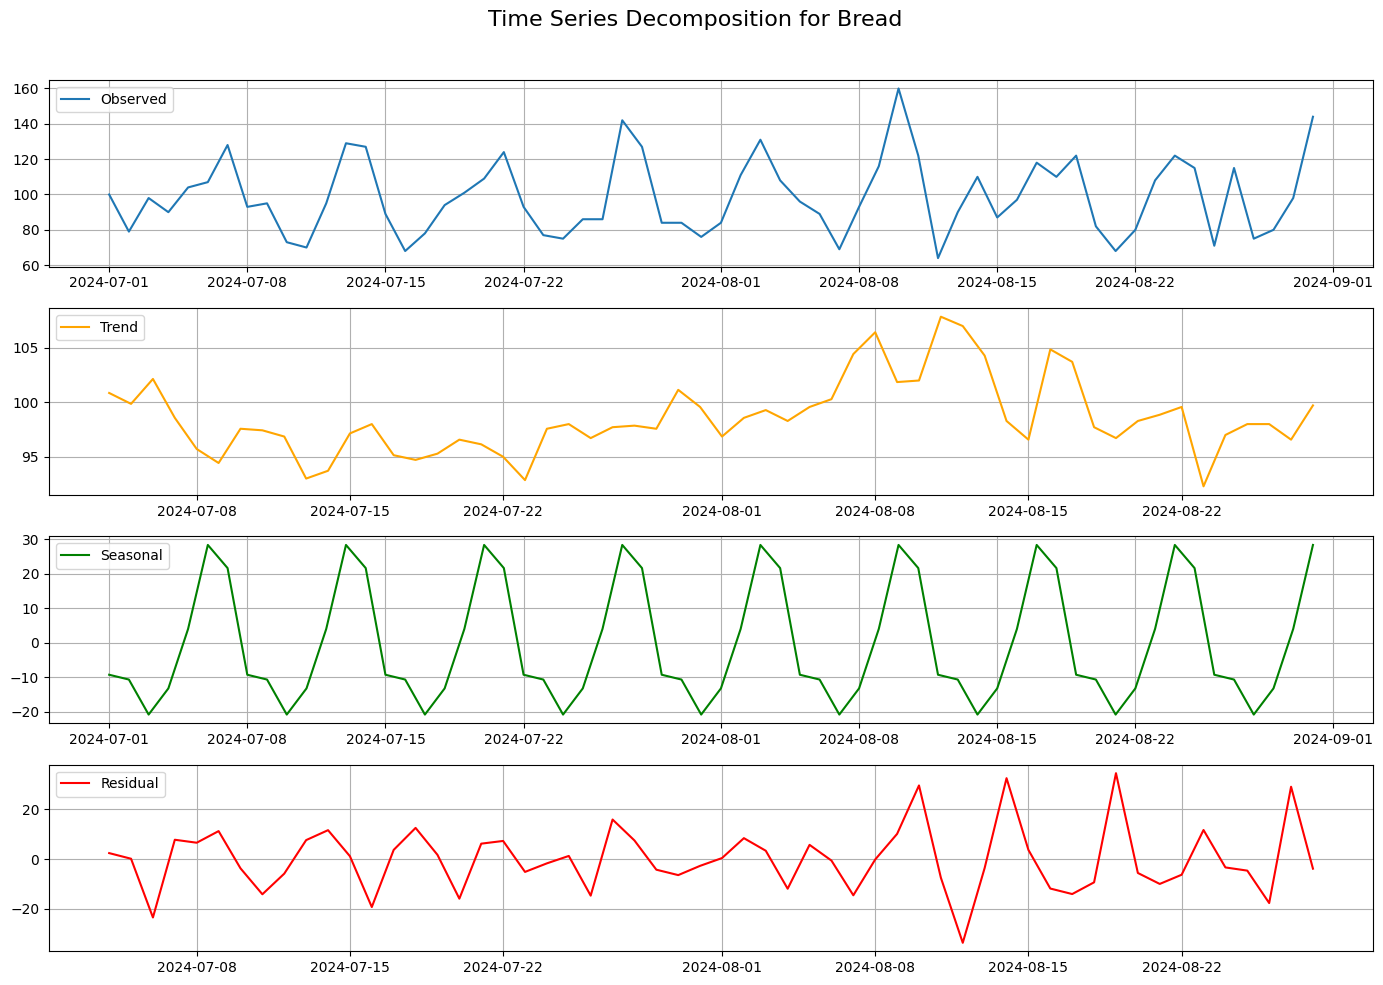

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series for each bakery item
decomposition_results = {}

for item in bakery_items:
    item_data = aggregated_data[aggregated_data['Item'] == item].set_index('Date')['Sold']
    decomposition = seasonal_decompose(item_data, model='additive', period=7)  # Weekly seasonality
    decomposition_results[item] = decomposition

# Plot the decomposition for one of the items as an example
item_to_plot = "Bread"
decomposition = decomposition_results[item_to_plot]

plt.figure(figsize=(14, 10))
plt.suptitle(f'Time Series Decomposition for {item_to_plot}', fontsize=16)

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [6]:
from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test and return results
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return {'ADF Statistic': result[0], 'p-value': result[1], 'Critical Values': result[4]}

# Performing ADF test on the original 'Sold' series and the residual for each item
adf_results = {}

for item in bakery_items:
    item_data = aggregated_data[aggregated_data['Item'] == item].set_index('Date')['Sold']
    residual = decomposition_results[item].resid.dropna()  # Remove NaN values before testing

    adf_results[item] = {
        'Original Series': adf_test(item_data),
        'Residual Series': adf_test(residual)
    }

adf_results


{'Bread': {'Original Series': {'ADF Statistic': -1.8951415848483202,
   'p-value': 0.3343501030971758,
   'Critical Values': {'1%': -3.568485864,
    '5%': -2.92135992,
    '10%': -2.5986616}},
  'Residual Series': {'ADF Statistic': -6.6600904042024265,
   'p-value': 4.871828712289076e-09,
   'Critical Values': {'1%': -3.5714715250448363,
    '5%': -2.922629480573571,
    '10%': -2.5993358475635153}}},
 'Fish Bun': {'Original Series': {'ADF Statistic': -6.690692896440145,
   'p-value': 4.116906749577289e-09,
   'Critical Values': {'1%': -3.552928203580539,
    '5%': -2.9147306250000002,
    '10%': -2.595137155612245}},
  'Residual Series': {'ADF Statistic': -5.587348340576798,
   'p-value': 1.353482348270275e-06,
   'Critical Values': {'1%': -3.5812576580093696,
    '5%': -2.9267849124681518,
    '10%': -2.6015409829867675}}},
 'Hotdog Bun': {'Original Series': {'ADF Statistic': -4.808998938435825,
   'p-value': 5.227068764145114e-05,
   'Critical Values': {'1%': -3.568485864,
    '5%'

In [7]:
# Apply first-order differencing to non-stationary series
differenced_series = {}

for item in bakery_items:
    item_data = aggregated_data[aggregated_data['Item'] == item].set_index('Date')['Sold']

    # Only apply differencing to non-stationary series based on previous ADF results
    if adf_results[item]['Original Series']['p-value'] > 0.05:
        differenced_series[item] = item_data.diff().dropna()  # First-order differencing
    else:
        differenced_series[item] = item_data  # Already stationary, no differencing needed

# Re-check stationarity with ADF test after differencing
differenced_adf_results = {}

for item, series in differenced_series.items():
    differenced_adf_results[item] = adf_test(series)

differenced_adf_results


{'Bread': {'ADF Statistic': -2.5333778838456635,
  'p-value': 0.1075628689424778,
  'Critical Values': {'1%': -3.568485864,
   '5%': -2.92135992,
   '10%': -2.5986616}},
 'Fish Bun': {'ADF Statistic': -6.690692896440145,
  'p-value': 4.116906749577289e-09,
  'Critical Values': {'1%': -3.552928203580539,
   '5%': -2.9147306250000002,
   '10%': -2.595137155612245}},
 'Hotdog Bun': {'ADF Statistic': -4.808998938435825,
  'p-value': 5.227068764145114e-05,
  'Critical Values': {'1%': -3.568485864,
   '5%': -2.92135992,
   '10%': -2.5986616}},
 'Tea Bun': {'ADF Statistic': -7.097394863490441,
  'p-value': 4.254195244087198e-10,
  'Critical Values': {'1%': -3.55770911573439,
   '5%': -2.9167703434435808,
   '10%': -2.59622219478738}}}

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define a dictionary to store fitted models
sarima_models = {}
sarima_orders = {}

# Fit SARIMA model for each bakery item
for item in bakery_items:
    item_data = differenced_series[item] if item in differenced_series else aggregated_data[aggregated_data['Item'] == item].set_index('Date')['Sold']

    # For simplicity, we'll use SARIMA(1,1,1)(1,1,1,7) as a starting point
    # p, d, q = (1, 1, 1) for non-seasonal part
    # P, D, Q, S = (1, 1, 1, 7) for seasonal part with weekly seasonality
    sarima_order = (1, 1, 1)
    seasonal_order = (1, 1, 1, 7)

    # Fit SARIMA model
    model = SARIMAX(item_data, order=sarima_order, seasonal_order=seasonal_order)
    fitted_model = model.fit(disp=False)

    # Store the model and orders
    sarima_models[item] = fitted_model
    sarima_orders[item] = (sarima_order, seasonal_order)

# Summary of one model as an example
sarima_models["Bread"].summary()
sarima_models["Fish Bun"].summary()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              Sold   No. Observations:                   62
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -225.598
Date:                           Tue, 06 Aug 2024   AIC                            461.197
Time:                                   18:32:59   BIC                            471.141
Sample:                               07-01-2024   HQIC                           465.032
                                    - 08-31-2024                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0301      0.188     -0.160      0.873      -0.399       0.339
ma.L1         -0.9998     46.340     -0.022      0.983     -91.825      89.825
ar.S.L7       -0.1911      0.286     -0.668      0.504      -0.751       0.369
ma.S.L7       -0.5277      0.323     -1.636      0.102      -1.160       0.105
sigma2       209.2316   9700.097      0.022      0.983   -1.88e+04    1.92e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.83   Prob(JB):                         0.75
Heteroskedasticity (H):               1.20   Skew:                             0.24
Prob(H) (two-sided):                  0.71   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
# Forecast sales for the next month (30 days)
forecast_period = 30
forecasts = {}

for item, model in sarima_models.items():
    forecast = model.get_forecast(steps=forecast_period)
    forecasts[item] = forecast.predicted_mean

# Create a DataFrame to display the forecasts
forecast_df = pd.DataFrame(forecasts)
forecast_df.index = pd.date_range(start="2024-09-01", periods=forecast_period)
forecast_df.head()


,Bread,Fish Bun,Hotdog Bun,Tea Bun
2024-09-01,-22.146564,127.643778,124.085030,17.190037
2024-09-02,-11.266045,87.591599,90.510047,-39.503738
2024-09-03,-18.870953,89.415241,78.381596,-4.033774
2024-09-04,-1.873665,92.837181,86.479305,-14.175294
2024-09-05,4.675498,87.314114,84.766545,15.171524


In [12]:
from prophet import Prophet  # or from fbprophet import Prophet for older versions

# Example for Bread
bread_data = aggregated_data[aggregated_data['Item'] == 'Bread'][['Date', 'Sold']]
bread_data.rename(columns={'Date': 'ds', 'Sold': 'y'}, inplace=True)

model = Prophet()
model.fit(bread_data)

# Forecasting for the next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# View the forecast
print(forecast[['ds', 'yhat']].tail(30))


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy16ff5la/bhjevrhr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy16ff5la/lxczn876.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85384', 'data', 'file=/tmp/tmpy16ff5la/bhjevrhr.json', 'init=/tmp/tmpy16ff5la/lxczn876.json', 'output', 'file=/tmp/tmpy16ff5la/prophet_model2hmrnrd8/prophet_model-20240806184202.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:42:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


           ds        yhat
62 2024-09-01  121.452169
63 2024-09-02   91.696911
64 2024-09-03   88.030216
65 2024-09-04   81.696863
66 2024-09-05   86.363546
67 2024-09-06  103.252506
68 2024-09-07  130.585896
69 2024-09-08  121.747234
70 2024-09-09   91.991976
71 2024-09-10   88.325281
72 2024-09-11   81.991928
73 2024-09-12   86.658611
74 2024-09-13  103.547571
75 2024-09-14  130.880962
76 2024-09-15  122.042299
77 2024-09-16   92.287041
78 2024-09-17   88.620346
79 2024-09-18   82.286993
80 2024-09-19   86.953676
81 2024-09-20  103.842636
82 2024-09-21  131.176027
83 2024-09-22  122.337364
84 2024-09-23   92.582106
85 2024-09-24   88.915411
86 2024-09-25   82.582058
87 2024-09-26   87.248741
88 2024-09-27  104.137701
89 2024-09-28  131.471092
90 2024-09-29  122.632429
91 2024-09-30   92.877171
